In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('datasets/climate_action_data.csv')
print(df.head())

  Sensor_ID        Date Soil_Moisture(%) Soil_pH Temperature(C) Humidity(%)  \
0  SEN-1000  2025-01-01            36.22    6.98           21.3        50.4   
1  SEN-1001  2025-01-02            76.55    5.03           23.5        34.3   
2  SEN-1002  2025-01-03            61.24    6.52           21.9        54.6   
3  SEN-1003  2025-01-04            51.91    6.62           24.0        48.7   
4  SEN-1004  2025-01-05            20.92    5.98           19.2        70.6   

  Crop_Type Fertilizer_Recommended(kg/ha) Irrigation_Recommended(mm)  \
0  Tomatoes                          67.6                       26.6   
1     Wheat                         130.4                        8.3   
2  Tomatoes                          36.0                       29.4   
3     Maize                          85.8                       19.6   
4     Wheat                          75.6                       29.9   

  Drone_Image_ID  
0       IMG-2000  
1       IMG-2001  
2       IMG-2002  
3       IMG-2003

**Inspecting Dataset**

In [4]:
print(df.info())
print(df.isnull().sum())
print(f"Duplicate records: {df.duplicated().sum()}")
print(df.dtypes)
print(df.apply(lambda x: x[x == 'error'].count()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Sensor_ID                      913 non-null    object
 1   Date                           909 non-null    object
 2   Soil_Moisture(%)               913 non-null    object
 3   Soil_pH                        913 non-null    object
 4   Temperature(C)                 913 non-null    object
 5   Humidity(%)                    913 non-null    object
 6   Crop_Type                      909 non-null    object
 7   Fertilizer_Recommended(kg/ha)  913 non-null    object
 8   Irrigation_Recommended(mm)     913 non-null    object
 9   Drone_Image_ID                 913 non-null    object
dtypes: object(10)
memory usage: 71.5+ KB
None
Sensor_ID                        0
Date                             4
Soil_Moisture(%)                 0
Soil_pH                          0


**Remove duplicates**

In [5]:
df = df.drop_duplicates()
print(f"Duplicate records after dropping: {df.duplicated().sum()}")
print(df.describe())

Duplicate records after dropping: 0
       Sensor_ID        Date Soil_Moisture(%) Soil_pH Temperature(C)  \
count        802         798              802     802            802   
unique       800         798              750     313            170   
top     SEN-1449  2026-03-26            error    7.54           28.8   
freq           2           1                5       9             11   

       Humidity(%) Crop_Type Fertilizer_Recommended(kg/ha)  \
count          802       798                           802   
unique         448         5                           595   
top           56.0     Wheat                          66.9   
freq             6       172                             5   

       Irrigation_Recommended(mm) Drone_Image_ID  
count                         802            802  
unique                        243            800  
top                           8.0       IMG-2449  
freq                           10              2  


**Remove Error and convert to Nan and also convert to correct data types**

In [7]:
import numpy as np

df.replace('error', np.nan, inplace=True)

numeric_columns = [
    'Soil_Moisture(%)',
    'Soil_pH',
    'Temperature(C)',
    'Humidity(%)',
    'Fertilizer_Recommended(kg/ha)',
    'Irrigation_Recommended(mm)'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


**handle missing values**

In [11]:
df = df[df.isnull().mean(axis=1) < 0.5]

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())


Explanatory Data Analysis

Histograms

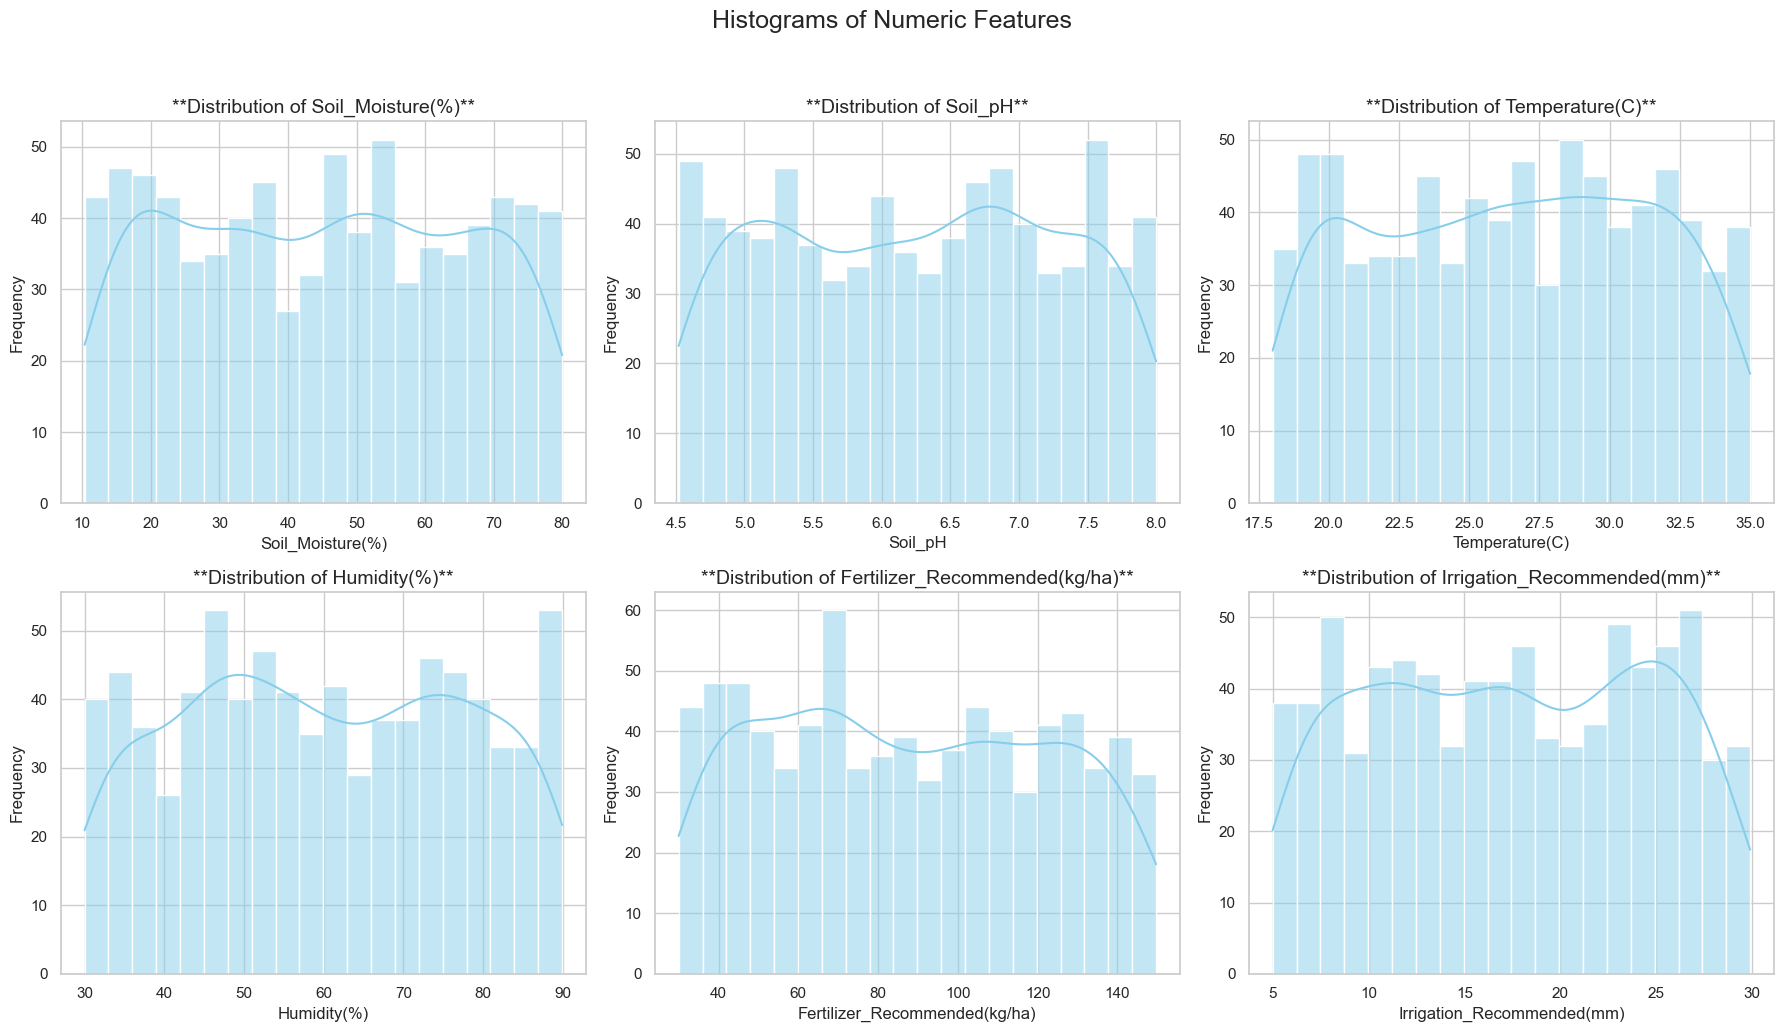

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], bins=20, ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'Distribution of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

plt.suptitle('Histograms of Numeric Features', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()


**Correlation Heatmap**

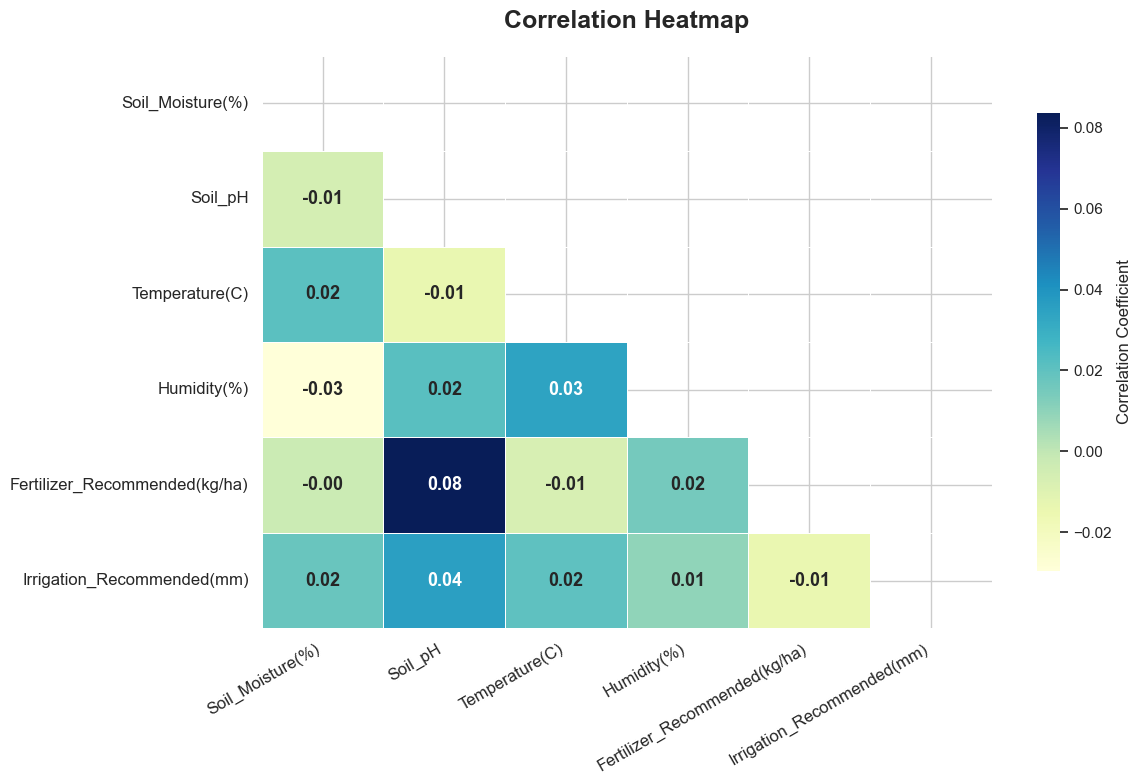

In [19]:
plt.figure(figsize=(12, 8))
corr = df[numeric_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
    annot_kws={"size": 13, "weight": "bold"}
)

plt.title('Correlation Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=30, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


**Analysis And Insights**

Variables most influencing fertilizer recommendation

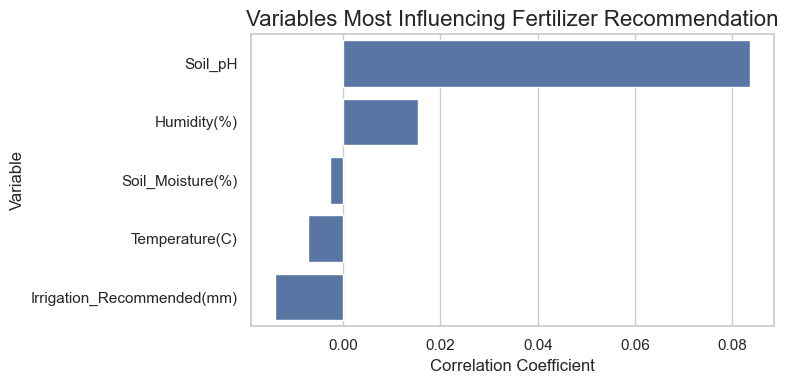

In [ ]:
fert_corr = corr['Fertilizer_Recommended(kg/ha)'].drop('Fertilizer_Recommended(kg/ha)').sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=fert_corr.values,
    y=fert_corr.index
)
plt.title('Variables Most Influencing Fertilizer Recommendation', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()


Crop with highest average soil moisture

In [17]:
highest_avg_soil_moisture = df.groupby('Crop_Type')['Soil_Moisture(%)'].mean().idxmax()
avg_value = df.groupby('Crop_Type')['Soil_Moisture(%)'].mean().max()
print(f"Crop with highest average soil moisture: {highest_avg_soil_moisture} ({avg_value:.2f}%)")

Crop with highest average soil moisture: Wheat (47.20%)


Irrigation adjustments (temperature > 30°C)

In [ ]:
high_temp_df = df[df['Temperature(C)'] > 30]

avg_irrigation_high_temp = high_temp_df['Irrigation_Recommended(mm)'].mean()

print(f"Average irrigation recommended when temperature > 30°C: {avg_irrigation_high_temp:.2f} mm")
print(f"Number of records with temperature > 30°C: {len(high_temp_df)}")

Average irrigation recommended when temperature > 30°C: 17.65 mm
Number of records with temperature > 30°C: 227
